# Convolutional Neural Networks

## Project: Write an Algorithm for a Dog Identification App 

---

In this notebook, some template code has already been provided for you, and you will need to implement additional functionality to successfully complete this project. You will not need to modify the included code beyond what is requested. Sections that begin with **'(IMPLEMENTATION)'** in the header indicate that the following block of code will require additional functionality which you must provide. Instructions will be provided for each section, and the specifics of the implementation are marked in the code block with a 'TODO' statement. Please be sure to read the instructions carefully! 

> **Note**: Once you have completed all of the code implementations, you need to finalize your work by exporting the Jupyter Notebook as an HTML document. Before exporting the notebook to html, all of the code cells need to have been run so that reviewers can see the final implementation and output. You can then export the notebook by using the menu above and navigating to **File -> Download as -> HTML (.html)**. Include the finished document along with this notebook as your submission.

In addition to implementing code, there will be questions that you must answer which relate to the project and your implementation. Each section where you will answer a question is preceded by a **'Question X'** header. Carefully read each question and provide thorough answers in the following text boxes that begin with **'Answer:'**. Your project submission will be evaluated based on your answers to each of the questions and the implementation you provide.

>**Note:** Code and Markdown cells can be executed using the **Shift + Enter** keyboard shortcut.  Markdown cells can be edited by double-clicking the cell to enter edit mode.

The rubric contains _optional_ "Stand Out Suggestions" for enhancing the project beyond the minimum requirements. If you decide to pursue the "Stand Out Suggestions", you should include the code in this Jupyter notebook.



---
### Why We're Here 

In this notebook, you will make the first steps towards developing an algorithm that could be used as part of a mobile or web app.  At the end of this project, your code will accept any user-supplied image as input.  If a dog is detected in the image, it will provide an estimate of the dog's breed.  If a human is detected, it will provide an estimate of the dog breed that is most resembling.  The image below displays potential sample output of your finished project (... but we expect that each student's algorithm will behave differently!). 

![Sample Dog Output](https://github.com/udacity/deep-learning-v2-pytorch/blob/master/project-dog-classification/images/sample_dog_output.png?raw=1)

In this real-world setting, you will need to piece together a series of models to perform different tasks; for instance, the algorithm that detects humans in an image will be different from the CNN that infers dog breed.  There are many points of possible failure, and no perfect algorithm exists.  Your imperfect solution will nonetheless create a fun user experience!

### The Road Ahead

We break the notebook into separate steps.  Feel free to use the links below to navigate the notebook.

* [Step 0](#step0): Import Datasets
* [Step 1](#step1): Detect Humans
* [Step 2](#step2): Detect Dogs
* [Step 3](#step3): Create a CNN to Classify Dog Breeds (from Scratch)
* [Step 4](#step4): Create a CNN to Classify Dog Breeds (using Transfer Learning)
* [Step 5](#step5): Write your Algorithm
* [Step 6](#step6): Test Your Algorithm

---
<a id='step0'></a>
## Step 0: Import Datasets

Make sure that you've downloaded the required human and dog datasets:
* Download the [dog dataset](https://s3-us-west-1.amazonaws.com/udacity-aind/dog-project/dogImages.zip).  Unzip the folder and place it in this project's home directory, at the location `/dogImages`. 

* Download the [human dataset](https://s3-us-west-1.amazonaws.com/udacity-aind/dog-project/lfw.zip).  Unzip the folder and place it in the home diretcory, at location `/lfw`.  

*Note: If you are using a Windows machine, you are encouraged to use [7zip](http://www.7-zip.org/) to extract the folder.*

In the code cell below, we save the file paths for both the human (LFW) dataset and dog dataset in the numpy arrays `human_files` and `dog_files`.

In [1]:
!pip install torch
!pip install torchvision
!pip install matplotlib
!pip install numpy

import torch
from torchvision import datasets, models
import torchvision.transforms as transforms
from torch.utils.data.sampler import SubsetRandomSampler
from torch import nn, optim
from torch.optim.lr_scheduler import MultiStepLR,StepLR
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
import time
%matplotlib inline

!pip install Pillow==4.0.0
!pip install PIL
!pip install image
import PIL.Image

    100% |████████████████████████████████| 591.8MB 29kB/s 
tcmalloc: large alloc 1073750016 bytes == 0x616b8000 @  0x7f0b09fe32a4 0x591a07 0x5b5d56 0x502e9a 0x506859 0x502209 0x502f3d 0x506859 0x504c28 0x502540 0x502f3d 0x506859 0x504c28 0x502540 0x502f3d 0x506859 0x504c28 0x502540 0x502f3d 0x507641 0x502209 0x502f3d 0x506859 0x504c28 0x502540 0x502f3d 0x507641 0x504c28 0x502540 0x502f3d 0x507641
    100% |████████████████████████████████| 61kB 2.9MB/s 
    100% |████████████████████████████████| 2.0MB 12.5MB/s 
  Found existing installation: Pillow 4.0.0
    Uninstalling Pillow-4.0.0:
      Successfully uninstalled Pillow-4.0.0
  [PIL]
You must restart the runtime in order to use newly installed versions.
    100% |████████████████████████████████| 5.6MB 7.4MB/s 
torchvision 0.2.1 has requirement pillow>=4.1.1, but you'll have pillow 4.0.0 which is incompatible.
  Found existing installation: Pillow 5.4.1
    Uninstalling Pillow-5.4.1:
      Successfully uninstalled Pillow-5.4.1
  [P

In [0]:
!wget -cq https://s3-us-west-1.amazonaws.com/udacity-aind/dog-project/dogImages.zip
!wget -cq https://s3-us-west-1.amazonaws.com/udacity-aind/dog-project/lfw.zip
!unzip -qq dogImages.zip
!unzip -qq lfw.zip

In [16]:
!pip install gdown
# transfer model
!gdown https://drive.google.com/uc?id=1eald-6p514-BkoMDsReo_LMN54DB6B9T

Downloading...
From: https://drive.google.com/uc?id=1eald-6p514-BkoMDsReo_LMN54DB6B9T
To: /content/model_transfer.pt
234MB [00:01, 147MB/s]


In [3]:
# check if CUDA is available
train_on_gpu = torch.cuda.is_available()

if not train_on_gpu:
    print('CUDA is not available.  Training on CPU ...')
else:
    print('CUDA is available!  Training on GPU ...')

CUDA is available!  Training on GPU ...


In [4]:
import numpy as np
from glob import glob

# load filenames for human and dog images
human_files = np.array(glob("lfw/*/*"))
dog_files = np.array(glob("dogImages/*/*/*"))

# print number of images in each dataset
print('There are %d total human images.' % len(human_files))
print('There are %d total dog images.' % len(dog_files))

There are 13233 total human images.
There are 8351 total dog images.


<a id='step1'></a>
## Step 1: Detect Humans

In this section, we use OpenCV's implementation of [Haar feature-based cascade classifiers](http://docs.opencv.org/trunk/d7/d8b/tutorial_py_face_detection.html) to detect human faces in images.  

OpenCV provides many pre-trained face detectors, stored as XML files on [github](https://github.com/opencv/opencv/tree/master/data/haarcascades).  We have downloaded one of these detectors and stored it in the `haarcascades` directory.  In the next code cell, we demonstrate how to use this detector to find human faces in a sample image.

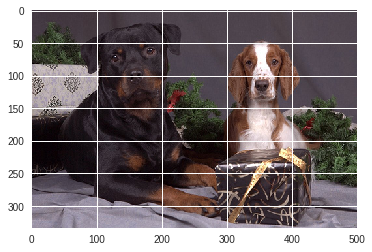

Number of faces detected: 0


In [5]:
import cv2                

# extract pre-trained face detector
face_cascade = cv2.CascadeClassifier('haarcascade_frontalface_alt.xml')
def show_image(img_path):
    # load color (BGR) image
    img = cv2.imread(img_path)
    # convert BGR image to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    # find faces in image
    faces = face_cascade.detectMultiScale(gray)

    # print number of faces detected in the image
    # print('Number of faces detected:', len(faces))

    # get bounding box for each detected face
    for (x,y,w,h) in faces:
      # add bounding box to color image
      cv2.rectangle(img,(x,y),(x+w,y+h),(255,0,0),2)

    # convert BGR image to RGB for plotting
    cv_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    # display the image, along with bounding box
    plt.imshow(cv_rgb)
    plt.show()
    return faces
    
print('Number of faces detected:', len(show_image(dog_files[28])))

Before using any of the face detectors, it is standard procedure to convert the images to grayscale.  The `detectMultiScale` function executes the classifier stored in `face_cascade` and takes the grayscale image as a parameter.  

In the above code, `faces` is a numpy array of detected faces, where each row corresponds to a detected face.  Each detected face is a 1D array with four entries that specifies the bounding box of the detected face.  The first two entries in the array (extracted in the above code as `x` and `y`) specify the horizontal and vertical positions of the top left corner of the bounding box.  The last two entries in the array (extracted here as `w` and `h`) specify the width and height of the box.

### Write a Human Face Detector

We can use this procedure to write a function that returns `True` if a human face is detected in an image and `False` otherwise.  This function, aptly named `face_detector`, takes a string-valued file path to an image as input and appears in the code block below.

In [0]:
# returns "True" if face is detected in image stored at img_path
def face_detector(img_path):
    img = cv2.imread(img_path)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    faces = face_cascade.detectMultiScale(gray)
    return len(faces) > 0

### (IMPLEMENTATION) Assess the Human Face Detector

__Question 1:__ Use the code cell below to test the performance of the `face_detector` function.  
- What percentage of the first 100 images in `human_files` have a detected human face?  
- What percentage of the first 100 images in `dog_files` have a detected human face? 

Ideally, we would like 100% of human images with a detected face and 0% of dog images with a detected face.  You will see that our algorithm falls short of this goal, but still gives acceptable performance.  We extract the file paths for the first 100 images from each of the datasets and store them in the numpy arrays `human_files_short` and `dog_files_short`.

__Answer:__ 
(You can print out your results and/or write your percentages in this cell)

In [7]:
from tqdm import tqdm

human_files_short = human_files[:100]
dog_files_short = dog_files[:100]

#-#-# Do NOT modify the code above this line. #-#-#

## TODO: Test the performance of the face_detector algorithm 
## on the images in human_files_short and dog_files_short.
faces = []
for i,file in enumerate(human_files_short):
    img = cv2.imread(file)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    fcs = face_cascade.detectMultiScale(gray)
    try:
        fcs.index
    except:
        faces.append(fcs)

        
    
faces2 = []
for i,file in enumerate(dog_files_short):
    img = cv2.imread(file)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    fcs = face_cascade.detectMultiScale(gray)
    try:
        fcs.index
    except:
        faces2.append(fcs)
    
# print number of faces detected in the image
print('Number of faces detected:', len(faces))
print('Number of faces detected and was dogs:', len(faces2))

Number of faces detected: 95
Number of faces detected and was dogs: 8


We suggest the face detector from OpenCV as a potential way to detect human images in your algorithm, but you are free to explore other approaches, especially approaches that make use of deep learning :).  Please use the code cell below to design and test your own face detection algorithm.  If you decide to pursue this _optional_ task, report performance on `human_files_short` and `dog_files_short`.

In [0]:
### (Optional) 
### TODO: Test performance of anotherface detection algorithm.
### Feel free to use as many code cells as needed.

---
<a id='step2'></a>
## Step 2: Detect Dogs

In this section, we use a [pre-trained model](http://pytorch.org/docs/master/torchvision/models.html) to detect dogs in images.  

### Obtain Pre-trained VGG-16 Model

The code cell below downloads the VGG-16 model, along with weights that have been trained on [ImageNet](http://www.image-net.org/), a very large, very popular dataset used for image classification and other vision tasks.  ImageNet contains over 10 million URLs, each linking to an image containing an object from one of [1000 categories](https://gist.github.com/yrevar/942d3a0ac09ec9e5eb3a).  

In [8]:
import torchvision.models as models

# define VGG16 model
vgg16 = models.vgg16(pretrained=True)

# move model to GPU if CUDA is available
if train_on_gpu:
    vgg16.cuda()

Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.torch/models/vgg16-397923af.pth
100%|██████████| 553433881/553433881 [00:22<00:00, 24597005.60it/s]


Given an image, this pre-trained VGG-16 model returns a prediction (derived from the 1000 possible categories in ImageNet) for the object that is contained in the image.

### (IMPLEMENTATION) Making Predictions with a Pre-trained Model

In the next code cell, you will write a function that accepts a path to an image (such as `'dogImages/train/001.Affenpinscher/Affenpinscher_00001.jpg'`) as input and returns the index corresponding to the ImageNet class that is predicted by the pre-trained VGG-16 model.  The output should always be an integer between 0 and 999, inclusive.

Before writing the function, make sure that you take the time to learn  how to appropriately pre-process tensors for pre-trained models in the [PyTorch documentation](http://pytorch.org/docs/stable/torchvision/models.html).

In [0]:
from PIL import Image

def process_image(img_path):
    image = Image.open(img_path).convert('RGB')
    
    means = [0.485, 0.456, 0.406]
    stds=[0.229, 0.224, 0.225]

    image_transforms = transforms.Compose([
                    transforms.Resize(224),
                    transforms.CenterCrop(224),
                    transforms.ToTensor(),
                    transforms.Normalize(means, stds)])
    
    # discard the transparent, alpha channel (that's the :3) and add the batch dimension
    image = image_transforms(image)[:3,:,:].unsqueeze(0)
    if train_on_gpu:
        image.cuda()
    return image

def VGG16_predict(img_path):
    '''
    Use pre-trained VGG-16 model to obtain index corresponding to 
    predicted ImageNet class for image at specified path
    Args:
        img_path: path to an image
    Returns:
        Index corresponding to VGG-16 model's prediction
    '''
    image = process_image(img_path)
    
    ## TODO: Complete the function.
    ## Load and pre-process an image from the given img_path
    ## Return the *index* of the predicted class for that image
    output = vgg16(image.cuda())
    ps = torch.exp(output)
    _, top_class = ps.topk(1,dim = 1)
    return top_class
    # predicted class index

### (IMPLEMENTATION) Write a Dog Detector

While looking at the [dictionary](https://gist.github.com/yrevar/942d3a0ac09ec9e5eb3a), you will notice that the categories corresponding to dogs appear in an uninterrupted sequence and correspond to dictionary keys 151-268, inclusive, to include all categories from `'Chihuahua'` to `'Mexican hairless'`.  Thus, in order to check to see if an image is predicted to contain a dog by the pre-trained VGG-16 model, we need only check if the pre-trained model predicts an index between 151 and 268 (inclusive).

Use these ideas to complete the `dog_detector` function below, which returns `True` if a dog is detected in an image (and `False` if not).

In [10]:
### returns "True" if a dog is detected in the image stored at img_path
print(VGG16_predict('dogImages/train/120.Pharaoh_hound/Pharaoh_hound_07762.jpg'))

def dog_detector(img_path):
    ## TODO: Complete the function.
    class_predicted = VGG16_predict(img_path)
    if class_predicted >150 and class_predicted < 269:
        return True
    else:
        return False # true/false

tensor([[173]], device='cuda:0')


In [11]:
dog_detector(human_files_short[0])

False

### (IMPLEMENTATION) Assess the Dog Detector

__Question 2:__ Use the code cell below to test the performance of your `dog_detector` function.  
- What percentage of the images in `human_files_short` have a detected dog?  
- What percentage of the images in `dog_files_short` have a detected dog?

__Answer:__ 


In [14]:
### TODO: Test the performance of the dog_detector function
### on the images in human_files_short and dog_files_short.
h_files_acc = 0
for file in human_files_short:
    if dog_detector(file):
        h_files_acc += 1
        
dog_files_acc = 0
for file in dog_files_short:
    if dog_detector(file):
        dog_files_acc += 1
        
print(h_files_acc, '%', ' of humans are classified as dogs') 
print(dog_files_acc, '%', 'of dogs are classified as dogs')                

1 %  of humans are classified as dogs
98 % of dogs are classified as dogs


We suggest VGG-16 as a potential network to detect dog images in your algorithm, but you are free to explore other pre-trained networks (such as [Inception-v3](http://pytorch.org/docs/master/torchvision/models.html#inception-v3), [ResNet-50](http://pytorch.org/docs/master/torchvision/models.html#id3), etc).  Please use the code cell below to test other pre-trained PyTorch models.  If you decide to pursue this _optional_ task, report performance on `human_files_short` and `dog_files_short`.

In [0]:
### (Optional) 
### TODO: Report the performance of another pre-trained network.
### Feel free to use as many code cells as needed.

---
<a id='step3'></a>
## Step 3: Create a CNN to Classify Dog Breeds (from Scratch)

Now that we have functions for detecting humans and dogs in images, we need a way to predict breed from images.  In this step, you will create a CNN that classifies dog breeds.  You must create your CNN _from scratch_ (so, you can't use transfer learning _yet_!), and you must attain a test accuracy of at least 10%.  In Step 4 of this notebook, you will have the opportunity to use transfer learning to create a CNN that attains greatly improved accuracy.

We mention that the task of assigning breed to dogs from images is considered exceptionally challenging.  To see why, consider that *even a human* would have trouble distinguishing between a Brittany and a Welsh Springer Spaniel.  

Brittany | Welsh Springer Spaniel
- | - 
<img src="https://github.com/udacity/deep-learning-v2-pytorch/blob/master/project-dog-classification/images/Brittany_02625.jpg?raw=1" width="100"> | <img src="https://github.com/udacity/deep-learning-v2-pytorch/blob/master/project-dog-classification/images/Welsh_springer_spaniel_08203.jpg?raw=1" width="200">

It is not difficult to find other dog breed pairs with minimal inter-class variation (for instance, Curly-Coated Retrievers and American Water Spaniels).  

Curly-Coated Retriever | American Water Spaniel
- | -
<img src="https://github.com/udacity/deep-learning-v2-pytorch/blob/master/project-dog-classification/images/Curly-coated_retriever_03896.jpg?raw=1" width="200"> | <img src="https://github.com/udacity/deep-learning-v2-pytorch/blob/master/project-dog-classification/images/American_water_spaniel_00648.jpg?raw=1" width="200">


Likewise, recall that labradors come in yellow, chocolate, and black.  Your vision-based algorithm will have to conquer this high intra-class variation to determine how to classify all of these different shades as the same breed.  

Yellow Labrador | Chocolate Labrador | Black Labrador
- | -
<img src="https://github.com/udacity/deep-learning-v2-pytorch/blob/master/project-dog-classification/images/Labrador_retriever_06457.jpg?raw=1" width="150"> | <img src="https://github.com/udacity/deep-learning-v2-pytorch/blob/master/project-dog-classification/images/Labrador_retriever_06455.jpg?raw=1" width="240"> | <img src="https://github.com/udacity/deep-learning-v2-pytorch/blob/master/project-dog-classification/images/Labrador_retriever_06449.jpg?raw=1" width="220">

We also mention that random chance presents an exceptionally low bar: setting aside the fact that the classes are slightly imabalanced, a random guess will provide a correct answer roughly 1 in 133 times, which corresponds to an accuracy of less than 1%.  

Remember that the practice is far ahead of the theory in deep learning.  Experiment with many different architectures, and trust your intuition.  And, of course, have fun!

### (IMPLEMENTATION) Specify Data Loaders for the Dog Dataset

Use the code cell below to write three separate [data loaders](http://pytorch.org/docs/stable/data.html#torch.utils.data.DataLoader) for the training, validation, and test datasets of dog images (located at `dogImages/train`, `dogImages/valid`, and `dogImages/test`, respectively).  You may find [this documentation on custom datasets](http://pytorch.org/docs/stable/torchvision/datasets.html) to be a useful resource.  If you are interested in augmenting your training and/or validation data, check out the wide variety of [transforms](http://pytorch.org/docs/stable/torchvision/transforms.html?highlight=transform)!

In [0]:
def get_loaders(means,stds):
    data_dir = 'dogImages'
    train_dir = data_dir + '/train'
    valid_dir = data_dir + '/valid'
    test_dir = data_dir + '/test'
    batch_size=64
    
    datatransforms = transforms.Compose([
        transforms.RandomHorizontalFlip(), 
        transforms.RandomRotation(15),
        transforms.RandomResizedCrop(224),
        transforms.ToTensor(),
        transforms.Normalize(means,stds)])

    valid_transforms = transforms.Compose([
        transforms.Resize(224),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize(means, stds)])

    train_data = datasets.ImageFolder(train_dir,transform = datatransforms)
    valid_data = datasets.ImageFolder(valid_dir,transform = valid_transforms)
    test_data = datasets.ImageFolder(test_dir,transform = valid_transforms)

    trainloader = torch.utils.data.DataLoader(train_data,batch_size=batch_size,shuffle=True)
    validloader = torch.utils.data.DataLoader(valid_data,batch_size=batch_size)
    testloader = torch.utils.data.DataLoader(test_data,batch_size=16)
    print(len(trainloader.dataset))
    print(len(validloader.dataset))
    return trainloader,validloader,testloader

**Question 3:** Describe your chosen procedure for preprocessing the data. 
- How does your code resize the images (by cropping, stretching, etc)?  What size did you pick for the input tensor, and why?
- Did you decide to augment the dataset?  If so, how (through translations, flips, rotations, etc)?  If not, why not?


**Answer**:


Initially my code is augmenting the data:
1. making a random flip with p=0.5 by default
2. 15 degrees of random rotation
3. resizing and cropping the image to 224
4. converting the images to tensor 
5. finally normalizing the data

Basically 6500 of images for training is not too much, knowing that we have 133 classes, so augmenting the data we can help the networks to understand more and in a better way the patterns in our data.


### (IMPLEMENTATION) Model Architecture

Create a CNN to classify dog breed.  Use the template in the code cell below.

In [0]:
class BnLayer(nn.Module):
    def __init__(self, inp, out, stride=2, kernel_size=3):
        super().__init__()
        self.conv = nn.Conv2d(inp, out, kernel_size=kernel_size, stride=stride, bias=False, padding=1)
        self.norm = nn.BatchNorm2d(out)
        
    def forward(self, x):
        x = F.relu(self.conv(x))
        x_norm = self.norm(x)
        return x_norm

In [0]:
class ResnetLayer(BnLayer):
    def forward(self, x): return x + super().forward(x)

In [0]:
class Resnet(nn.Module):
    def __init__(self, layers, c):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 10, kernel_size=5, stride=1, padding=2)
        self.layers = nn.ModuleList([BnLayer(layers[i], layers[i+1]) for i in range(len(layers) - 1)])
        self.layers2 = nn.ModuleList([ResnetLayer(layers[i+1], layers[i + 1], 1) for i in range(len(layers) - 1)])
        self.layers3 = nn.ModuleList([ResnetLayer(layers[i+1], layers[i + 1], 1) for i in range(len(layers) - 1)])
        self.out = nn.Linear(layers[-1], c)
        
    def forward(self, x):
        x = self.conv1(x)
        for l,l2,l3 in zip(self.layers, self.layers2, self.layers3):
            x = l3(l2(l(x)))
        x = F.adaptive_max_pool2d(x, 1)
        x = x.view(x.size(0), -1)
        return F.log_softmax(self.out(x), dim=-1)

In [0]:
class Net(nn.Module):
    def __init__(self, layers, classes, p=0.5):
        super().__init__()
        
        self.conv1 = BnLayer(3, 64, stride=2, kernel_size=7)
        self.pool1 = nn.MaxPool2d(3,2)
        
        self.layers = nn.ModuleList([BnLayer(layers[i], layers[i+1]) for i in range(len(layers) - 1)])
        self.layers2 = nn.ModuleList([ResnetLayer(layers[i+1], layers[i + 1], 1) for i in range(len(layers) - 1)])
        self.layers3 = nn.ModuleList([ResnetLayer(layers[i+1], layers[i + 1], 1) for i in range(len(layers) - 1)])
        self.layers4 = nn.ModuleList([ResnetLayer(layers[i+1], layers[i + 1], 1) for i in range(len(layers) - 1)])
        self.layers5 = nn.ModuleList([ResnetLayer(layers[i+1], layers[i + 1], 1) for i in range(len(layers) - 1)])
        
        self.out = nn.Linear(layers[-1], classes)
        self.drop = nn.Dropout(p)
        
    def forward(self, x):
        x = self.pool1(F.relu(self.conv1(x)))
        for l,l2,l3,l4,l5 in zip(self.layers, self.layers2, self.layers3, self.layers4, self.layers5):
            x = l5(l4(l3(l2(l(x)))))
        x = F.adaptive_max_pool2d(x, 1)
        x = x.view(x.size(0), -1)
        x = self.drop(x)
        return F.log_softmax(self.out(x), dim=-1)

In [0]:
net = Net([64,128,256,512,1024], 133, 0.0)
if train_on_gpu:
    net.cuda()

In [0]:
net

Net(
  (conv1): BnLayer(
    (conv): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(1, 1), bias=False)
    (norm): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (pool1): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  (layers): ModuleList(
    (0): BnLayer(
      (conv): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (norm): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BnLayer(
      (conv): Conv2d(128, 256, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (norm): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (2): BnLayer(
      (conv): Conv2d(256, 512, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (norm): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (3): BnLayer(
      (conv): Conv2d(512

__Question 4:__ Outline the steps you took to get to your final CNN architecture and your reasoning at each step.  

__Answer:__ 

**1.BnLayer:** there's no way to avoid us of use BatchNorm, it speed our training significantly and additionally let us arrive to a lower loss and if that's not sufficient this magic trick help us avoid the Vanishing gradient problem.

**2. ResnetLayer:** Then of some experiences with previous datasets and reading some papers, I saw that resnets are especially good for Image classification letting us stack deeper neural networks without making worse the loss as a frequent Convnet cause.

**3. Net:** This Class is basically a stack of module layers which give us a deep residual network.


**How I designed the structure?**
**1.** Well, I started with a basic one, 3 ConvLayers and two layers for the classifier, LR = 0.01, then of even 6 epochs the improve was 0, so I decided to reduce the learning rate, as in the unfreezing process used in transfer learning to improve our network a bit more we require a super low learning rate, I remembered it, and I thought that our model doesn't know anything so probably the moves of the gradient descent needs to be too much lower.new LR = 0.0001.

**2.** with the new learn rate I was able to see a bit of improvement in the network anything significant but a valuable improve from 0 to something.

**3.** I explored the structure of some pre-trained models, and I see how deep they are, it means that my network was too simple and was not extracting sufficient features, so time makes a deep model.

**4.** With a basic Deep Batch Norm Network I stacked three modules with three sublayers for each one, in 10 epochs I was able to achieve 0.13 as accuracy achieving state of the art required for this project.

**5** Finally as I said and explained previously I decided to stack some Resnets individually, five modules each one with a deep of four batch norm layer, Conv + BatchNorm.

**RESULTS** 
As you'll see below, in less than 20 epochs I was able to achieve more than 0.25 of valid accuracy and more than 0.3 in training, a good result or decent, but it can be improved a lot more, probably adding more modules or adding more sublayers, creating submodules, well, a process of tune and see.

### (IMPLEMENTATION) Specify Loss Function and Optimizer

Use the next code cell to specify a [loss function](http://pytorch.org/docs/stable/nn.html#loss-functions) and [optimizer](http://pytorch.org/docs/stable/optim.html).  Save the chosen loss function as `criterion_scratch`, and the optimizer as `optimizer_scratch` below.

In [0]:
criterion_scratch = nn.NLLLoss()
optimizer_scratch =optim.Adam(net.parameters(), 0.0001)

### (IMPLEMENTATION) Train and Validate the Model

Train and validate your model in the code cell below.  [Save the final model parameters](http://pytorch.org/docs/master/notes/serialization.html) at filepath `'model_scratch.pt'`.

In [0]:
def validate_training(model,dataloader,criterion,train_on_gpu):
    accuracy = 0
    valid_loss = 0
    with torch.no_grad():
        for images,labels in dataloader:
            if train_on_gpu:
                images, labels = images.cuda(),labels.cuda()
            log_ps = model(images)
            loss = criterion(log_ps,labels)
            valid_loss += loss.item()

            ps = torch.exp(log_ps)
            top_p, top_class = ps.topk(1,dim = 1)
            equals = top_class == labels.view(*top_class.shape)
            accuracy += torch.mean(equals.type(torch.FloatTensor))

    return valid_loss,accuracy

In [0]:
def train(n_epochs, model, optimizer, criterion,scheduler, save_path):
    valid_loss_min = np.Inf
    valid_losses = []
    train_losses = []

    for e in range(n_epochs):
        print(e+1)
        training_loss = 0
        training_accuracy = 0
        if scheduler is not None:
            scheduler.step()
        print('training')
        model.train()
        for images,labels in trainloader:
            if train_on_gpu:
                images, labels = images.cuda(),labels.cuda()
            optimizer.zero_grad()
            output = model(images)
            loss = criterion(output,labels)
            loss.backward()
            optimizer.step()
            training_loss += loss.item()

            ps = torch.exp(output)
            top_p, top_class = ps.topk(1,dim = 1)
            equals = top_class == labels.view(*top_class.shape)
            training_accuracy += torch.mean(equals.type(torch.FloatTensor))

        model.eval()
        print('validating')
        valid_loss, valid_accuracy = validate_training(model,validloader,criterion,train_on_gpu)  

        train_loss = training_loss/len(trainloader)
        train_losses.append(train_loss)
        valid_loss = valid_loss/len(validloader)
        valid_losses.append(valid_loss)

        # print training/validation statistics 
        print('Epoch: {} \tTraining Loss: {:.6f} \tTraining Accuracy: {:.6f}'
              ' \tValidation Loss: {:.6f} \tValidation Accuracy: {:.6f}'.format(
            e+1, train_loss,training_accuracy/len(trainloader), valid_loss,valid_accuracy/len(validloader)))

        # save model if validation loss has decreased
        if valid_loss <= valid_loss_min:
            print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(
            valid_loss_min,
            valid_loss))
            torch.save(model.state_dict(), save_path)
            valid_loss_min = valid_loss
    print('Training completed for ',n_epochs)
    
    plt.plot(valid_losses,label = 'Valid loss')
    plt.plot(train_losses,label = 'Train loss')
    plt.xlabel('epochs')
    plt.ylabel('loss')
    x_ticks = [x for x in range(0,n_epochs,2)]
    plt.xticks(x_ticks)
    plt.show()            
    

In [25]:
means = [0.485, 0.456, 0.406]
stds=[0.229, 0.224, 0.225]
trainloader, validloader, testloader = get_loaders(means,stds)

6680
835


In [0]:
from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True
# This was used due to the images at some point was throwing an error

1
training
validating
Epoch: 1 	Training Loss: 5.079491 	Training Accuracy: 0.026885 	Validation Loss: 5.039101 	Validation Accuracy: 0.030134
Validation loss decreased (inf --> 5.039101).  Saving model ...
2
training
validating
Epoch: 2 	Training Loss: 4.663533 	Training Accuracy: 0.043204 	Validation Loss: 4.676841 	Validation Accuracy: 0.045759
Validation loss decreased (5.039101 --> 4.676841).  Saving model ...
3
training
validating
Epoch: 3 	Training Loss: 4.439670 	Training Accuracy: 0.061062 	Validation Loss: 4.586883 	Validation Accuracy: 0.058036
Validation loss decreased (4.676841 --> 4.586883).  Saving model ...
4
training
validating
Epoch: 4 	Training Loss: 4.222297 	Training Accuracy: 0.080159 	Validation Loss: 4.271955 	Validation Accuracy: 0.071429
Validation loss decreased (4.586883 --> 4.271955).  Saving model ...
5
training
validating
Epoch: 5 	Training Loss: 4.063427 	Training Accuracy: 0.095387 	Validation Loss: 4.330305 	Validation Accuracy: 0.095982
6
training
val

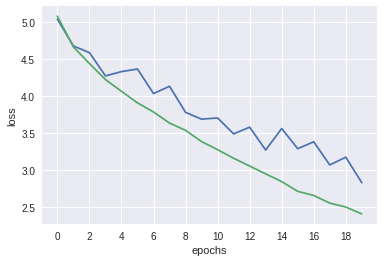

In [0]:
model = train(20,net,optimizer_scratch,criterion_scratch,None,'model_scratch.pt')

In [0]:
model = Net([64,128,256,512,1024], 133, 0.0)
model.load_state_dict(torch.load('model_scratch.pt',map_location=lambda storage, loc: storage),strict=False)
if train_on_gpu:
    model.cuda()

### (IMPLEMENTATION) Test the Model

Try out your model on the test dataset of dog images.  Use the code cell below to calculate and print the test loss and accuracy.  Ensure that your test accuracy is greater than 10%.

In [0]:
def test(testloader, model, criterion, use_cuda):

    # monitor test loss and accuracy
    test_loss = 0.
    correct = 0.
    total = 0.

    model.eval()
    for batch_idx, (data, target) in enumerate(testloader):
        # move to GPU
        if use_cuda:
            data, target = data.cuda(), target.cuda()
        # forward pass: compute predicted outputs by passing inputs to the model
        output = model(data)
        # calculate the loss
        loss = criterion(output, target)
        # update average test loss 
        test_loss = test_loss + ((1 / (batch_idx + 1)) * (loss.data - test_loss))
        # convert output probabilities to predicted class
        pred = output.data.max(1, keepdim=True)[1]
        # compare predictions to true label
        correct += np.sum(np.squeeze(pred.eq(target.data.view_as(pred))).cpu().numpy())
        total += data.size(0)
            
    print('Test Loss: {:.6f}\n'.format(test_loss))

    print('\nTest Accuracy: %2d%% (%2d/%2d)' % (
        100. * correct / total, correct, total))


In [0]:
# call test function   
test(testloader, model, criterion_scratch, train_on_gpu)

Test Loss: 2.771702


Test Accuracy: 30% (253/836)


---
<a id='step4'></a>
## Step 4: Create a CNN to Classify Dog Breeds (using Transfer Learning)

You will now use transfer learning to create a CNN that can identify dog breed from images.  Your CNN must attain at least 60% accuracy on the test set.

### (IMPLEMENTATION) Specify Data Loaders for the Dog Dataset

Use the code cell below to write three separate [data loaders](http://pytorch.org/docs/master/data.html#torch.utils.data.DataLoader) for the training, validation, and test datasets of dog images (located at `dogImages/train`, `dogImages/valid`, and `dogImages/test`, respectively). 

If you like, **you are welcome to use the same data loaders from the previous step**, when you created a CNN from scratch.

In [0]:
## TODO: Specify data loaders
# same data loaders as before

### (IMPLEMENTATION) Model Architecture

Use transfer learning to create a CNN to classify dog breed.  Use the code cell below, and save your initialized model as the variable `model_transfer`.

In [0]:
model_transfer = models.resnet152(pretrained = True)

Downloading: "https://download.pytorch.org/models/resnet152-b121ed2d.pth" to /root/.torch/models/resnet152-b121ed2d.pth
100%|██████████| 241530880/241530880 [00:06<00:00, 38952927.84it/s]


In [0]:
model_transfer.fc

Linear(in_features=2048, out_features=1000, bias=True)

In [0]:
for param in model_transfer.parameters():
    param.requires_grad = False

model_transfer.fc = nn.Sequential(nn.BatchNorm1d(2048),
                         nn.Linear(2048,133))  
if train_on_gpu:
    model_transfer.cuda()

__Question 5:__ Outline the steps you took to get to your final CNN architecture and your reasoning at each step.  Describe why you think the architecture is suitable for the current problem.

__Answer:__ 
**1.** I used resnet by the reasons I explained above but densenet201 is pretty good too, I used resnet152 because we have aprox 50 photos for each category for training, something really small at all, so I need a model able to take as most features as posible, so it means a really deep model, densenet201 and resnet152 are good options for this process.

**why just one layer for the classifier?**
First I added batchnorm because it makes our training better, and just one layer because we are trying to find 1 category across 133 different, if I start to add more layers the network will start to find more complex patterns accross each category detected, patterns that we are not interested in, like 10 subcategories for each breed for example.


### (IMPLEMENTATION) Specify Loss Function and Optimizer

Use the next code cell to specify a [loss function](http://pytorch.org/docs/master/nn.html#loss-functions) and [optimizer](http://pytorch.org/docs/master/optim.html).  Save the chosen loss function as `criterion_transfer`, and the optimizer as `optimizer_transfer` below.

In [0]:
criterion_transfer = nn.CrossEntropyLoss()
optimizer_transfer = optim.Adam(model_transfer.fc.parameters(),0.001)

### (IMPLEMENTATION) Train and Validate the Model

Train and validate your model in the code cell below.  [Save the final model parameters](http://pytorch.org/docs/master/notes/serialization.html) at filepath `'model_transfer.pt'`.

1
training
validating
Epoch: 1 	Training Loss: 1.798668 	Training Accuracy: 0.616319 	Validation Loss: 0.445354 	Validation Accuracy: 0.878348
Validation loss decreased (inf --> 0.445354).  Saving model ...
2
training
validating
Epoch: 2 	Training Loss: 0.801959 	Training Accuracy: 0.788095 	Validation Loss: 0.363356 	Validation Accuracy: 0.881696
Validation loss decreased (0.445354 --> 0.363356).  Saving model ...
3
training
validating
Epoch: 3 	Training Loss: 0.659549 	Training Accuracy: 0.816667 	Validation Loss: 0.373401 	Validation Accuracy: 0.883929
4
training
validating
Epoch: 4 	Training Loss: 0.651537 	Training Accuracy: 0.818800 	Validation Loss: 0.357772 	Validation Accuracy: 0.883929
Validation loss decreased (0.363356 --> 0.357772).  Saving model ...
5
training
validating
Epoch: 5 	Training Loss: 0.600328 	Training Accuracy: 0.833978 	Validation Loss: 0.360960 	Validation Accuracy: 0.887277
Training completed for  5


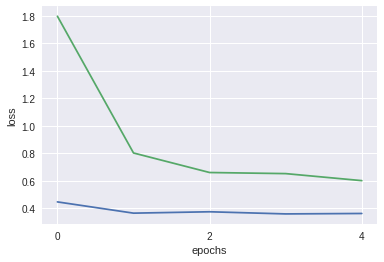

AttributeError: ignored

In [0]:
# train the model
model_transfer = train(5,model_transfer,optimizer_transfer,criterion_transfer,None,'model_transfer.pt')

# load the model that got the best validation accuracy (uncomment the line below)
model_transfer.load_state_dict(torch.load('model_transfer.pt'))

The code provided was not working for the model restoring 

In [0]:
model_transfer = models.resnet152()
model_transfer.fc = nn.Sequential(nn.BatchNorm1d(2048),
                         nn.Linear(2048,133))  
model_transfer.load_state_dict(torch.load('model_transfer.pt',map_location=lambda storage, loc: storage),strict=False)
if train_on_gpu:
    model_transfer.cuda()

### (IMPLEMENTATION) Test the Model

Try out your model on the test dataset of dog images. Use the code cell below to calculate and print the test loss and accuracy.  Ensure that your test accuracy is greater than 60%.

In [26]:
test(testloader, model_transfer, criterion_transfer, train_on_gpu)

Test Loss: 0.399977


Test Accuracy: 88% (738/836)


### (IMPLEMENTATION) Predict Dog Breed with the Model

Write a function that takes an image path as input and returns the dog breed (`Affenpinscher`, `Afghan hound`, etc) that is predicted by your model.  

In [0]:
train_dir = 'dogImages/train'
batch_size=64
    
datatransforms = transforms.Compose([
    transforms.RandomHorizontalFlip(), 
    transforms.RandomRotation(15),
    transforms.RandomResizedCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(means,stds)])
    
train_data = datasets.ImageFolder(train_dir,transform = datatransforms)

In [29]:
### TODO: Write a function that takes a path to an image as input
### and returns the dog breed that is predicted by the model.

# list of class names by index, i.e. a name can be accessed like class_names[0]
class_names = [item[4:].replace("_", " ") for item in train_data.classes]
#print(class_names)
def predict_breed_transfer(img_path):
    # load the image and return the predicted breed
    model_transfer.eval()
    with torch.no_grad():
        image = process_image(img_path)
        output = model_transfer(image.cuda())
        ps = torch.exp(output)
        _, top_class = ps.topk(1,dim = 1)
        return class_names[top_class]
    
print(predict_breed_transfer('dogImages/train/001.Affenpinscher/Affenpinscher_00001.jpg'))  

Affenpinscher


---
<a id='step5'></a>
## Step 5: Write your Algorithm

Write an algorithm that accepts a file path to an image and first determines whether the image contains a human, dog, or neither.  Then,
- if a __dog__ is detected in the image, return the predicted breed.
- if a __human__ is detected in the image, return the resembling dog breed.
- if __neither__ is detected in the image, provide output that indicates an error.

You are welcome to write your own functions for detecting humans and dogs in images, but feel free to use the `face_detector` and `human_detector` functions developed above.  You are __required__ to use your CNN from Step 4 to predict dog breed.  

Some sample output for our algorithm is provided below, but feel free to design your own user experience!

![Sample Human Output](https://github.com/udacity/deep-learning-v2-pytorch/blob/master/project-dog-classification/images/sample_human_output.png?raw=1)


### (IMPLEMENTATION) Write your Algorithm


	Hello human


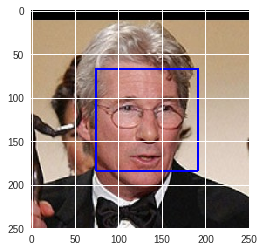

	You look like a  Boxer


In [30]:
### TODO: Write your algorithm.
### Feel free to use as many code cells as needed.

def run_app(img_path):
    ## handle cases for a human face, dog, and neither
    dog_detected = dog_detector(img_path)
    if dog_detected == True:
        print('\n\tIs a dog')
    else:
        if face_detector(img_path):
            print('\n\tHello human')
        else:
            print('\n\tHello Other thing')
    show_image(img_path)
    print('\tYou look like a ',predict_breed_transfer(img_path));

run_app(human_files_short[20])    

---
<a id='step6'></a>
## Step 6: Test Your Algorithm

In this section, you will take your new algorithm for a spin!  What kind of dog does the algorithm think that _you_ look like?  If you have a dog, does it predict your dog's breed accurately?  If you have a cat, does it mistakenly think that your cat is a dog?

### (IMPLEMENTATION) Test Your Algorithm on Sample Images!

Test your algorithm at least six images on your computer.  Feel free to use any images you like.  Use at least two human and two dog images.  

__Question 6:__ Is the output better than you expected :) ?  Or worse :( ?  Provide at least three possible points of improvement for your algorithm.

__Answer:__ (Three possible points for improvement)

**There are  so many things to improve my model!**
1. more epochs, 20 looks promising.
2. tune more the learning rate, try a bit higher and lower values
3. tune a bit the batch size, I used 64  as batch size due to is relatively big and make the train a bit faster than 32, 24 or 16.
4. use a scheduler, it definitely could help a lot, varying the LR when our loss starts to stop the decrease.
5. the of achieving more than 93 at least with the previous process, unfreeze the whole model improving a bit the layers who are detecting features.


	Hello human


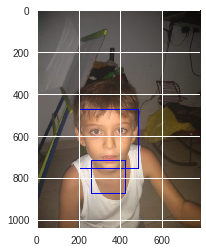

	You look like a  Pomeranian

	Hello human


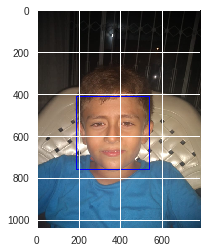

	You look like a  Norwich terrier

	Hello human


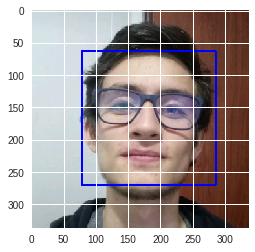

	You look like a  Lhasa apso

	Is a dog


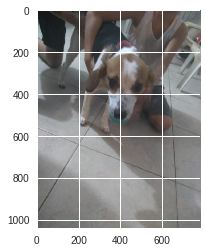

	You look like a  Beagle

	Hello Other thing


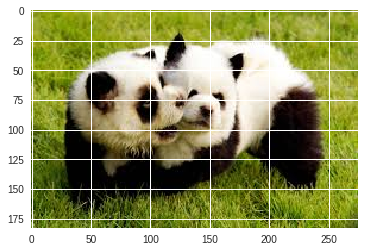

	You look like a  Chow chow

	Is a dog


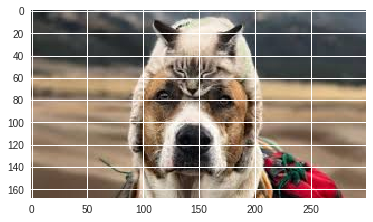

	You look like a  American staffordshire terrier


In [31]:
## TODO: Execute your algorithm from Step 6 on
## at least 6 images on your computer.
## Feel free to use as many code cells as needed.
own_human_files = np.array(['nicolas.jpeg','emmanuel.jpeg','joan.png'])
own_dog_files = np.array(['manchas.jpeg','dog2.jpg','dog3.jpg'])

## suggested code, below
for file in np.hstack((own_human_files,own_dog_files)):
    run_app(file)

## Conclusion
taking a look at the 5th photo, my network detected those dogs as a Other thing, probably a bear, is understandable, the colors are black and white.

Obviously but no added before as a point of improvement, a higher dataset will improve our results a lot also a dataset with more breeds we are just identifying 133 breeds and out there are aproximately 343 breeds.